In [1]:
import pandas as pd

In [2]:
import os
os.chdir("F:\Blue Sky\EVERYTHING\DATA SCIENCE\Apziva\Happy Customers")

In [3]:
hc = pd.read_csv("ACME-HappinessSurvey2020.csv")
hc.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


# Exploratory Data Analysis

In [4]:
hc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


In [5]:
hc.describe()

,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

### Check class balancing

In [7]:
hc['Y'].value_counts()
# Class is balanced

1    69
0    57
Name: Y, dtype: int64

In [8]:
X = hc.drop(columns = 'Y')
y = hc['Y']
print(X.head())
print(y.head())

   X1  X2  X3  X4  X5  X6
0   3   3   3   4   2   4
1   3   2   3   5   4   3
2   5   3   3   3   3   5
3   5   4   3   3   3   5
4   5   4   3   3   3   5
0    0
1    0
2    1
3    0
4    0
Name: Y, dtype: int64


### Train Test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)
print(X_train.head())
print(X_train.shape)
print(X_test.shape)

     X1  X2  X3  X4  X5  X6
116   3   4   4   5   1   3
13    4   2   4   5   4   3
33    3   2   4   4   4   5
75    3   2   3   3   4   4
26    3   3   3   5   5   5
(100, 6)
(26, 6)


In [10]:
X_train

,X1,X2,X3,X4,X5,X6
116,3,4,4,5,1,3
13,4,2,4,5,4,3
33,3,2,4,4,4,5
75,3,2,3,3,4,4
26,3,3,3,5,5,5
...,...,...,...,...,...,...
67,4,1,1,3,4,4
64,4,1,3,4,4,4
117,5,1,5,5,5,5
47,1,1,1,3,1,4


## Logistic Regression

In [32]:
X_sm = X
import statsmodels.api as sm
X_sm = sm.add_constant(X_sm)
logit_model = sm.Logit(y,X_sm)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.637875
         Iterations 5
                        Results: Logit
Model:              Logit            Pseudo R-squared: 0.074   
Dependent Variable: Y                AIC:              174.7445
Date:               2021-05-12 13:25 BIC:              194.5985
No. Observations:   126              Log-Likelihood:   -80.372 
Df Model:           6                LL-Null:          -86.764 
Df Residuals:       119              LLR p-value:      0.046597
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     5.0000                                     
-----------------------------------------------------------------
         Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-----------------------------------------------------------------
const   -3.5674     1.4891   -2.3957   0.0166   -6.4859   -0.6489
X1       0.5738     0.2888    1.9866   0.0470    0.0077    1.1400
X2      -0.0937  

### X1 is the most statistically significant variable and X4 is least significant

In [12]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [13]:
y_pred_logit = logreg.predict(X_test)

In [14]:
print('Accuracy of Logistic Regression on the test set {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of Logistic Regression on the test set 0.62


In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_logit)
print(confusion_matrix)

[[ 5  8]
 [ 2 11]]


In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_logit))

              precision    recall  f1-score   support

           0       0.71      0.38      0.50        13
           1       0.58      0.85      0.69        13

    accuracy                           0.62        26
   macro avg       0.65      0.62      0.59        26
weighted avg       0.65      0.62      0.59        26



# K Nearest Neighbors

In [17]:
from sklearn.neighbors import KNeighborsClassifier

In [18]:
from sklearn import metrics

In [19]:
k_range = range(1,100)
scores = {}
score_list = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    scores[k] = knn.score(X_test, y_test)
    score_list.append(knn.score(X_test, y_test))

In [20]:
max(score_list)
# k = 10

0.7307692307692307

In [21]:
max(scores, key=scores.get)

10

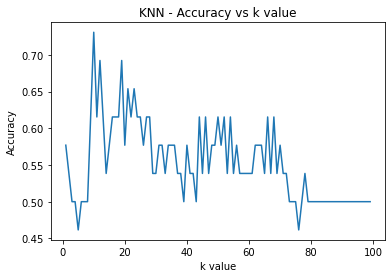

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(k_range, score_list)
plt.xlabel('k value')
plt.ylabel('Accuracy')
plt.title('KNN - Accuracy vs k value')
plt.show()

# Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state = 0)
dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_test)

In [24]:
y_pred_dtc

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1], dtype=int64)

In [25]:
print(classification_report(y_test, y_pred_dtc))

              precision    recall  f1-score   support

           0       0.50      0.54      0.52        13
           1       0.50      0.46      0.48        13

    accuracy                           0.50        26
   macro avg       0.50      0.50      0.50        26
weighted avg       0.50      0.50      0.50        26



#### Cross Validation

In [26]:
from sklearn.model_selection import cross_val_score
cross_val_score(dtc, X_train, y_train, cv = 10)

array([0.7, 0.7, 0.5, 0.6, 0.8, 0.5, 0.6, 0.6, 0.8, 0.4])

# Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [28]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.56      0.38      0.45        13
           1       0.53      0.69      0.60        13

    accuracy                           0.54        26
   macro avg       0.54      0.54      0.53        26
weighted avg       0.54      0.54      0.53        26



# Gradient Boosting

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state = 0)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

In [30]:
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.50      0.38      0.43        13
           1       0.50      0.62      0.55        13

    accuracy                           0.50        26
   macro avg       0.50      0.50      0.49        26
weighted avg       0.50      0.50      0.49        26



# Summary

## Highest accuracy achieved is 73.07% using KNN algorithm when k=10